In [26]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, LatentDirichletAllocation, KernelPCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFECV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, Normalizer, LabelEncoder, OrdinalEncoder,MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

%matplotlib inline

In [2]:
labelled = pd.read_csv('train.csv')
unlabelled = pd.read_csv('test.csv')

In [3]:
ID = unlabelled.Id

In [4]:
data = pd.concat([labelled, unlabelled], axis= 0)

# Data Exploring

In [5]:
# Check features with null values
nan_features = data.isnull().sum()[data.isnull().sum() != 0].index.drop(['SalePrice'])

In [6]:
# Check features with null values
data.isnull().sum()[data.isnull().sum() != 0]

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

In [7]:
# Check numeric and categorical features
data.dtypes.value_counts()

object     43
int64      26
float64    12
dtype: int64

In [8]:
# Creat a list of categorical features
categorical = data.dtypes[data.dtypes == 'object'].index.tolist()
# Creat a list of integer number features
numeric = data.dtypes[data.dtypes != 'object'].index.drop(['Id','SalePrice']).tolist()

# Data Cleaning

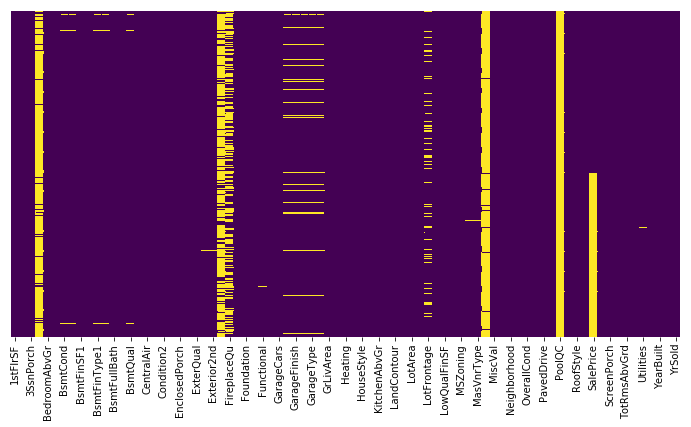

In [9]:
# Visualizing null values
plt.figure(figsize= (12,6))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap= 'viridis')

## Imputing missing values

In this dataset, some features has the value of 'NA' which means 'Not existing' or 'None' and it's not actually missing value.<br/>
To distinguish between 'NA' which means 'Not existing' and 'NA' which means actually missing value, we will check the other features describing the same aspect of the house and we will try to infere whether it's actually missing value or not.

In [10]:
# Filling missing values in each feature based on feature data dtype.
for i in range(len(nan_features)):
    if data[nan_features].dtypes[i] == 'O':
        imp1 = SimpleImputer(strategy= 'most_frequent')
        data[[nan_features[i]]] = imp1.fit_transform(data[[nan_features[i]]])
    else :
        imp2 = SimpleImputer(strategy= 'median')
        data[[nan_features[i]]] = imp2.fit_transform(data[[nan_features[i]]])

In [11]:
data.isnull().sum()[data.isnull().sum() != 0]

SalePrice    1459
dtype: int64

# Feature Engineering

In [12]:
# Convert Categorical features into numeric features.
le = LabelEncoder()
for ii in range(len(categorical)):
    data[categorical[ii]] = le.fit_transform(data[categorical[ii]])

In [13]:
# Getting dummy variables fot Categorical features
data = pd.get_dummies(data, columns=categorical, drop_first=True)

In [14]:
# Scaling numeric features
null_label = data.SalePrice.isnull()
with_label = data.SalePrice.isnull() == False
scaler = StandardScaler()
data.loc[with_label, numeric] = scaler.fit_transform(data.loc[with_label, numeric])
data.loc[null_label, numeric] = scaler.transform(data.loc[null_label, numeric])

C:\Users\moazm\Anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\moazm\Anaconda3\envs\ML\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [17]:
data['SalePrice'] = np.log(data.SalePrice)

In [19]:
# Splitting data back into labelled/unlabelled sets
labelled = data.loc[data.SalePrice.isnull() == False]
unlabelled = data.loc[data.SalePrice.isnull() == True].drop(columns = ['SalePrice'])

# Train/Validation/Test.

We will split the labelled data into 3 sets:
1. Training set: used for model training. (Size = %70)
2. Validation set: used for hyperparameter tunning. (Size = %15)
3. Test set: used for model assessment and comparison of different models. (Size = %15)

We will perform data split on two steps using train_test_split function:
   1. we split data into training set and other set.
   2. we split the other set into validation set and test set.

In [20]:
x_train, x_other, y_train, y_other = train_test_split(
                labelled.drop(columns=['SalePrice']), labelled.SalePrice, train_size=0.7)

In [21]:
x_valid, x_test, y_valid, y_test = train_test_split(
                                    x_other, y_other, train_size=0.5)

# 5. Features/Target

We will seperate the features and target columns from the label data so that it can be used in the feature selection step.

In [22]:
features = labelled.drop(columns=['SalePrice'])
target = labelled.SalePrice
                

# Model Building

## Baseline Model - LassoCV Regression

In [23]:
ridge = RidgeCV(cv= 10)

### Feature Selection

#### VarianceThreshold method

In [24]:
threshold = np.arange(1, 10, 0.5) *1e-2

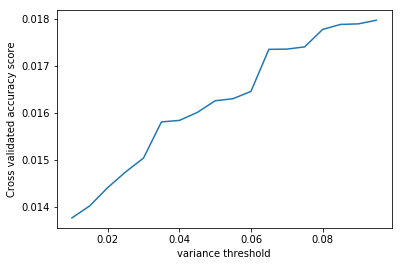

In [27]:
scores = []
for i in threshold:
    selector = VarianceThreshold(threshold= i)
    selected_features = selector.fit_transform(features)
    ridge.fit(selected_features, target)
    y_pred = ridge.predict(features.loc[:, selector.get_support()])
    scores.append(mean_squared_error(target, y_pred))

# Plot variance threshold VS. cross-validated scores for training sets.
plt.figure()
plt.xlabel("variance threshold")
plt.ylabel("Cross validated accuracy score")
plt.plot(threshold, np.array(scores))

In [29]:
print('The minimum MSE score is:', np.min(np.array(scores)))

The minimum MSE score is: 0.013767564209549754


The highest accuracy is obtained after execluding features whose variance is less than 0.01

####  SelectKbest method

In [31]:
number_of_features = list(range(1,x_train.shape[1]))

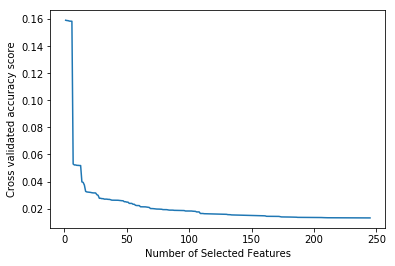

In [34]:
scores_k = []
for i in number_of_features:
    selector = SelectKBest(k=i)
    selected_features = selector.fit_transform(features, target)
    ridge.fit(selected_features, target)
    y_pred = ridge.predict(features.loc[:, selector.get_support()])
    scores_k.append(mean_squared_error(target, y_pred))

# Plot number of selected features VS. cross-validated scores for training sets.
plt.figure()
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross validated accuracy score")    
plt.plot(number_of_features, scores_k)

In [35]:
print("Minimum MSE is :", min(scores_k))

Minimum MSE is : 0.01314101771155026


In [36]:
print("Optimal number of features :", np.argmin(np.array(scores_k)) + 1)

Optimal number of features : 245


####  RFECV method

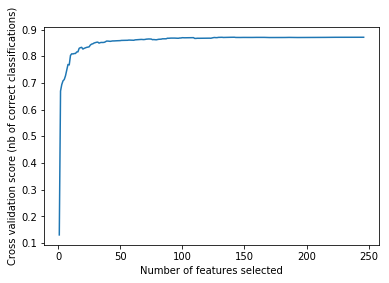

In [38]:
selector = RFECV(ridge, step= 1, cv= 5)
selector.fit(features, target)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)

In [39]:
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 142


In [41]:
print("Minimum MSE score is :", np.min(selector.grid_scores_))

Minimum MSE score is : 0.13005720623547717


#### SelectFromModel method

In [45]:
threshold = np.arange(1, 5, 0.1) *1e-2

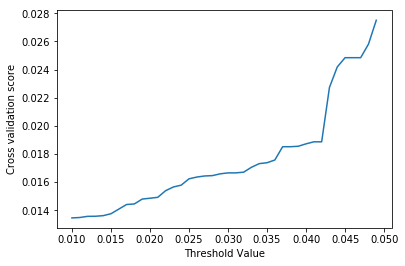

In [46]:
scores_sfm = []
for i in threshold:
    selector = SelectFromModel(ridge, threshold= i)
    selector.fit(features, target)
    selected_features = features.loc[:, selector.get_support()]
    ridge.fit(selected_features, target)
    y_pred = ridge.predict(selected_features)
    scores_sfm.append(mean_squared_error(target, y_pred))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Threshold Value")
plt.ylabel("Cross validation score")    
plt.plot(threshold, scores_sfm)

In [47]:
print("Minimum MSE score is :", np.min(np.array(scores_sfm)))

Minimum MSE score is : 0.013456420646663057


In [48]:
print("Optimal threshold :", threshold[np.argmin(np.array(scores_sfm))])

Optimal threshold : 0.01


We conclude the best feature selection method is RFECV.

In [49]:
# Fit the model with features selected by RFECV method and the training set
selector =RFECV(ridge)
selector.fit(features, target)
selected_features = selector.get_support()

In [51]:
ridge = RidgeCV(cv= 10)
ridge.fit(features.loc[:, selected_features], target)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=10, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [52]:
# Make Prediction fot test data
pred_ridge = pd.DataFrame(np.exp(ridge.predict(unlabelled.loc[:, selected_features])), 
                          columns=['SalePrice'], dtype='int32')

In [54]:
ridge_model = pd.concat([ID, pred_ridge], axis=1)

In [56]:
ridge_model.to_csv('ridgeModel.csv', index= False)